In the angiogenesis model $c$ is the concentration of angiogenic factors, $f$ is the concentration of fibronectin and $n$ is the concentration of endothelial cells.  

The Rules used to update this three concentrations are the following:

\begin{align}
&n(i,j)_{\text{next}} = P_{0} n(i,j) + P_{2}n(i-1, j) + P_{3}n(i+1,j) + P_{3}n(i,j-1) + P_{4}n(i,j+1)\\
&f(i,j)_{\text{next}} = f(i,j)\left(1 - k\gamma n(i,j)\right) + k\beta n(i,j)\\
&c(i,j)_{\text{next}} = c(i,j)\left(1 - k\eta n(i,j)\right)
\end{align}

where $P_{0}$, $P_{1}$, $P_{2}$, $P_{3}$ and $P_{4}$ are the probabilities that a tip cell remains stationary, moves left, moves right, moves up or moves down. These are computed as follows:

\begin{align}
&P_{0} = 1 - \frac{4kD}{h^{2}} + \frac{k\alpha \chi\left(c(i,j)\right)}{4h^{2} (1 + \alpha c(i,j))}\left[ (c(i-1, j) - c(i+1, j))^{2} + (c(i,j-1) - c(i,j+1))^{2}\right]\\
&-\frac{k\chi(c(i,j))}{h^{2}}\left(c(i,j+1) + c(i,j-1) + c(i-1,j) + c(i+1,j) -4c(i,j)\right)\\
&-\frac{k\rho}{h^{2}}\left(f(i, j+1) + f(i, j-1) - 4f(i,j) + f(i-1,j) + f(i+1,j)\right)
\end{align}

\begin{equation}
P_{1} = \frac{kD}{h^{2}} - \frac{k}{4h^{2}}\left[\chi\left(c(i,j)\right)\left(c(i,j+1) - c(i,j-1)\right) + \rho \left(f(i,j+1) - f(i, j-1)\right)\right]
\end{equation}

\begin{equation}
P_{2} = \frac{kD}{h^{2}} + \frac{k}{4h^{2}}\left[\chi\left(c(i,j)\right)\left(c(i,j+1) - c(i,j-1)\right) + \rho\left(f(i,j+1) - f(i,j-1)\right)\right]
\end{equation}

\begin{equation}
P_{3} = \frac{kD}{h^{2}} + \frac{k}{4h^{2}}\left[\chi\left(c(i,j)\right) \left(c(i-1,j) - c(i+1,j)\right) + \rho\left(f(i-1,j) - f(i+1,j)\right)\right]
\end{equation}


\begin{equation}
P_{4} = \frac{kD}{h^{2}} - \frac{k}{4h^{2}}\left[\chi\left(c(i,j)\right) \left(c(i-1,j) - c(i+1,j)\right) + \rho\left(f(i-1,j) - f(i+1,j)\right)\right]
\end{equation}


In the previous equations:

\begin{equation}
\chi\left(c\right) = \frac{\chi_{0}}{1 + \delta c}
\end{equation}

So what will happen is that we will have tip points that will move with those probabilities. We can also create new tip points by branching and that will require the following 3 conditions:

<ol>
    <li>Age of the tip is greater than a quantity $T_{\text{age}}$</li>
    <li>$n$  is greater than $\frac{k_{n}}{c(i,j)}$ where $k_{n}$ is a constant </li>
    <li>Has space to branch</li>    
</ol>

If those 3 conditions are met, the probability of brainching will be $P_{b}$ and that probability will be dependent on the local angiogenic factor concentration. The article uses a certain curve but it doesn't give an equation so i will use just:

\begin{equation}
P_{b} = c(i,j)
\end{equation}

The other thing is that if in some moments two tip points collide, only one will follow.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import random
from tqdm import tqdm

In [146]:
class Direction(Enum):
    LEFT = 0
    RIGHT = 1
    UP = 2
    DOWN = 3
    CENTER = 4


class TipCell:
    def __init__(self, i, j):
        self.x = j
        self.y = i
        self.life = 0
    
    def move(self, direction, width, height):
        if(direction == Direction.UP and self.y - 1 >= 1):
            self.y = self.y - 1
        elif(direction == Direction.DOWN and self.y + 1<= height - 2):
            self.y = self.y + 1
        elif(direction == Direction.LEFT and self.x - 1 >= 1):
            self.x = self.x - 1
        elif(direction == Direction.RIGHT and self.x + 1 <= width - 2):
            self.x = self.x + 1
        
        self.life = self.life + 1
        
        


class AngiogenesisModel:
    
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.k = 1/(((2*10**-3)**2)/(2.9*10**-7))
        self.h = 0.005
        self.D = 0.00035
        self.alpha = 0.6
        self.chi0 = 0.38
        self.rho = 0.34
        #self.rho = 0
        self.beta = 0.05
        self.gamma = 0.1
        self.eta = 0.1
        self.tAge = 2
        self.delta = 1
        self.kn = 0.75
        self.maxBranches = 50
        
        self.resetSystem()
        
        
    def resetSystem(self):
        #Endothelial cells
        self.nInitial = np.zeros((self.height, self.width))
        #Fibronectin
        self.fInitial = np.zeros((self.height, self.width))
        #angiogenic factors 
        self.cInitial = np.zeros((self.height, self.width))
        
        self.tipCells = []
        
        self.occupiedCells = np.zeros((self.height, self.width))
    
    def resetOccupiedCells(self):
        self.occupiedCells = np.zeros((self.height, self.width))
    
    def setInitialConcentrations(self, prolifLocations):
        nProlif = sum(sum(prolifLocations))

        for i in range(1,self.height-1):
            for j in range(1,self.width-1):
                if(prolifLocations[i,j] == 1):
                    self.cInitial[i,j] = 0.5
                    for s in range(1,self.height-1):
                        for l in range(1,self.width-1):
                            distance = np.sqrt(((s - i)*self.h)**2 + ((l - j)*self.h)**2)
                            if(distance < 0.1):
                                self.cInitial[s,l] = self.cInitial[s,l] + 2
                            else:
                                nu = (np.sqrt(5) - 0.1)/(np.sqrt(5) - 1)
                                self.cInitial[s,l] = self.cInitial[s,l] + (((nu - distance)**2)/(nu - 0.1))
                            
                            #else:
                                #self.cInitial[s,l] = self.cInitial[s,l] + 1
                    
                self.fInitial[i,j] = 0.4
                self.nInitial[i,j] = 0
        self.cInitial = self.cInitial/(np.max(self.cInitial))
                
                
    def setTipCells(self, tipCellLocations):
        n = np.size(tipCellLocations,0)
        m = np.size(tipCellLocations,1)
        if(n != self.height or m != self.width):
            print("Matrix sizes don't coincide")
            return -1
        
        for i in range(0,n):
            for j in range(0,m):
                if(tipCellLocations[i,j] == 1):
                    self.tipCells.append(TipCell(i,j))
                    self.occupiedCells[i,j] = 1
                    self.nInitial[i,j] = 1
                    #for s in range(1,self.height-1):
                        #for l in range(1, self.width - 1):
                            #if(i != s or j != l):
                                #distance = np.sqrt((s - i)**2 + (l - j)**2)
                                #self.nInitial[s,l] = self.nInitial[s,l] + (1/distance)
                            #else:
                                #self.nInitial[s,l] = self.nInitial[s,l] + 1
                    
        #self.nInitial = self.nInitial/(sum(sum(self.nInitial)))
                    
                
                
    
    
    def evolveSystem(self, nSteps):
        self.nMatrix = np.zeros((self.height, self.width, nSteps + 1))
        self.cMatrix = np.zeros((self.height, self.width, nSteps + 1))
        self.fMatrix = np.zeros((self.height, self.width, nSteps + 1))
        self.occupiedCellsMovie = np.zeros((self.height, self.width, nSteps + 1))
        
        self.nMatrix[:,:,0] = self.nInitial
        self.cMatrix[:,:,0] = self.cInitial
        self.fMatrix[:,:,0] = self.fInitial
        self.occupiedCellsMovie[:,:,0] = self.occupiedCells
        
        for i in tqdm(range(1,nSteps+1)):
            self.step(i)
            self.occupiedCellsMovie[:,:,i] = self.occupiedCells
            
    def step(self, step):
        c = self.cMatrix[:,:,step-1]
        f = self.fMatrix[:,:,step-1]
        n = self.nMatrix[:,:,step-1]
        for i in range(1,self.height-1):
            for j in range(1,self.width-1):
                p0 = 1 - ((4*self.k*self.D/(self.h**2))) + ((self.k*self.alpha*self.chi(c[i,j]))/(4*(self.h**2)*(1 + self.alpha*c[i,j])))*((c[i, j+1] - c[i, j-1])**2 + (c[i-1,j] - c[i+1,j])**2)-((self.k*self.chi(c[i,j]))/(self.h**2))*(c[i+1,j] + c[i-1,j] + c[i,j+1] + c[i,j-1] -4*c[i,j]) - ((self.k*self.rho)/(self.h**2))*(f[i+1, j] + f[i-1, j] - 4*f[i,j] + f[i,j+1] + f[i,j-1])
                p1 = ((self.k*self.D)/(self.h**2)) - (self.k/(4*self.h**2))*(self.chi(c[i,j])*(c[i,j+1] - c[i,j-1]) + self.rho*(f[i,j+1] - f[i, j-1]))
                p2 = ((self.k*self.D)/(self.h**2)) + (self.k/(4*self.h**2))*(self.chi(c[i,j])*(c[i,j+1] - c[i,j-1]) + self.rho*(f[i,j+1] - f[i, j-1]))
                p3 = ((self.k*self.D)/(self.h**2)) + (self.k/(4*self.h**2))*(self.chi(c[i,j])*(c[i-1,j] - c[i+1,j]) + self.rho*(f[i-1,j] - f[i+1, j]))
                p4 = ((self.k*self.D)/(self.h**2)) - (self.k/(4*self.h**2))*(self.chi(c[i,j])*(c[i-1,j] - c[i+1,j]) + self.rho*(f[i-1,j] - f[i+1, j]))
                    
                    
                
                probArray = self.getProbabilities([p0, p1, p2, p3, p4])
                p0 = probArray[0]
                p1 = probArray[1]
                p2 = probArray[2]
                p3 = probArray[3]
                p4 = probArray[4]
                
                
                self.nMatrix[i,j,step] = p0*self.occupiedCells[i,j] + p1*self.occupiedCells[i,j-1] + p2*self.occupiedCells[i,j+1] + p3*self.occupiedCells[i-1,j] + p4*self.occupiedCells[i+1,j]
                self.fMatrix[i,j,step] = f[i,j]*(1 - self.k*self.gamma*n[i,j]) + self.k*self.beta*n[i,j]
                self.cMatrix[i,j,step] = c[i,j]*(1 - self.k*self.eta*n[i,j])
                
                if(self.tipOccupied(i,j)):
                    #print("Centro: "+str(p0))
                    #print("Izquierda: "+str(p1))
                    #print("Derecha: "+str(p2))
                    #print("Arriba: "+str(p3))
                    #print("Abajo: "+str(p4))
                    direction = self.getDirection(probArray)
                    index = self.getTipIndex(i,j)
                    self.tipCells[index].move(direction, width, height)
                    self.occupiedCells[self.tipCells[index].y, self.tipCells[index].x] = 1
                    oldTip = self.tipCells[index]
                    self.removeRepeatedTips(self.tipCells[index], index)
                    #Branching
                    availableBranchingPositions = self.getAvailableBranchingPositions(i,j)
                    index = self.getTipIndex(i,j)
                    if(oldTip.life > self.tAge and len(availableBranchingPositions) > 0 and n[i,j] > self.kn/c[i,j]):
                        Pn = c[i,j]/np.max(c)
                        if(random.random() < Pn and len(self.tipCells) < self.maxBranches):
                            print("Branched")
                            positionIndex = random.randint(0,len(availableBranchingPositions)- 1)
                            branchPosition = availableBranchingPositions[positionIndex]
                            newTip = TipCell(branchPosition[0], branchPosition[1])
                            self.tipCells.append(newTip)
                            self.occupiedCells[newTip.y, newTip.x] = 1
                            self.removeRepeatedTips(newTip, len(self.tipCells)-1)
                        
                            
                    
                    
    
    def getAvailableBranchingPositions(self, i,j):
        availablePositions = []
        for s in range(-1,2):
            for l in range(-1,2):
                if(not self.tipOccupied(i + s, j + l)):
                    availablePositions.append([i+s, j+l])
        
        return availablePositions
    
    def chi(self, x):
        return self.chi0/(1 + self.delta*x)
    
    def tipOccupied(self, i,j):
        for s in range(0,len(self.tipCells)):
            if(self.tipCells[s].x == j and self.tipCells[s].y == i):
                return True
        
        return False
    
    def getTipIndex(self, i,j):
        for s in range(0,len(self.tipCells)):
            if(self.tipCells[s].x == j and self.tipCells[s].y == i):
                return s
    def getProbabilities(self, probArray):
        
        
        probArray = np.array(probArray)
        maxVal = np.max(probArray)
        minVal = np.min(probArray)
        for i in range(0,len(probArray)):
            probArray[i] = (probArray[i] - minVal)/(maxVal - minVal)
        
        probArray = probArray/sum(probArray)
        return probArray
    
    def getDirection(self, probArray):
    
        cumulative = 0
        rand = random.random()
        for i in range(0,len(probArray)):
            if(rand >= cumulative and rand <= cumulative + probArray[i]):
                
                if(i == 0):
                    return Direction.CENTER
                elif(i == 1):
                    return Direction.LEFT
                elif(i == 2):
                    return Direction.RIGHT
                elif(i == 3):
                    return Direction.UP
                elif(i == 4):
                    return Direction.DOWN
            else:
                cumulative = cumulative + probArray[i]
    
    def removeRepeatedTips(self, tip, index):
        indexToRemove = []
        for i in range(0, len(self.tipCells)):
            if(index != i and tip.x == self.tipCells[i].x and tip.y == self.tipCells[i].y):
                indexToRemove.append(i)
                
        for i in range(0,len(indexToRemove)):
            self.tipCells.pop(indexToRemove[i])
        #if(len(indexToRemove) > 0):
            #print("Removed "+str(len(indexToRemove))+ " Branches")
        
    
    def getPicture(self, tipCellLocations, proliferatingLocations, vasculaturePicture):
        
        tipCellColor = [245/255.0, 103/255.0, 91/255.0]
        proliferatingColor = [58/255.0, 252/255.0, 84/255.0]
        vasculatureColor = [240/255.0, 199/255.0, 53/255.0]
        
        picture = np.zeros((self.height, self.width, 3))
        
        for i in range(0,self.height):
            for j in range(0,self.width):
                if(vasculaturePicture[i,j] == 1):
                    picture[i,j,:] = vasculatureColor
            
                if(proliferatingLocations[i,j] == 1):
                    picture[i,j,:] = proliferatingColor
                       
                if(tipCellLocations[i,j] == 1):
                    picture[i,j,:] = tipCellColor
        
        return picture
        
        
        
        
        
        
    
        
            
            
        
        
        
        
    
    
        
        
    
    
    
                    
    

Let's try it

True
98.0
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.49905039 0.50075    ... 0.50075    0.49905039 0.        ]
 [0.         0.50281874 0.50453721 ... 0.50453721 0.50281874 0.        ]
 ...
 [0.         0.83994392 0.84627875 ... 0.84627875 0.83994392 0.        ]
 [0.         0.84300223 0.83728062 ... 0.02712645 0.01507025 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


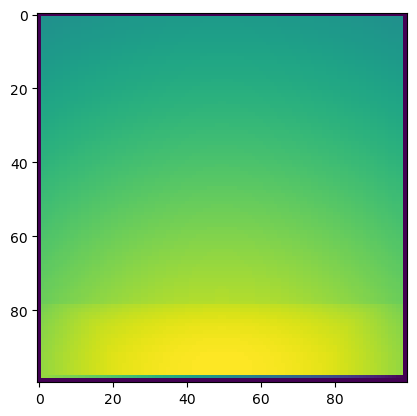

In [147]:
width = 100
height = 100

angiogenesisModel = AngiogenesisModel(width, height)
proliferatingLocations = np.zeros((height, width))
proliferatingLocations[height-2,1:width-1] = 1
print(proliferatingLocations[height-2, 4] == 1)
angiogenesisModel.setInitialConcentrations(proliferatingLocations)
tipCellLocations = np.zeros((height, width))
for i in range(1, width - 1):
    if(i%10 == 0):
        tipCellLocations[1,i] = 1

angiogenesisModel.setTipCells(tipCellLocations)


plt.figure()
plt.imshow(angiogenesisModel.cInitial)

print(angiogenesisModel.cInitial)

 50%|████████████████████▋                    | 101/200 [00:23<00:23,  4.23it/s]

Branched


 52%|█████████████████████▎                   | 104/200 [00:24<00:22,  4.19it/s]

Branched


 52%|█████████████████████▌                   | 105/200 [00:24<00:22,  4.17it/s]

Branched


 54%|█████████████████████▉                   | 107/200 [00:25<00:22,  4.18it/s]

Branched


 54%|██████████████████████▏                  | 108/200 [00:25<00:22,  4.18it/s]

Branched


 56%|██████████████████████▊                  | 111/200 [00:26<00:21,  4.15it/s]

Branched


 57%|███████████████████████▎                 | 114/200 [00:27<00:20,  4.11it/s]

Branched


 58%|███████████████████████▊                 | 116/200 [00:27<00:20,  4.11it/s]

Branched


 64%|██████████████████████████▍              | 129/200 [00:30<00:16,  4.19it/s]

Branched


 70%|████████████████████████████▋            | 140/200 [00:33<00:14,  4.18it/s]

Branched
Branched
Branched


 70%|████████████████████████████▉            | 141/200 [00:33<00:14,  4.17it/s]

Branched
Branched


 72%|█████████████████████████████▎           | 143/200 [00:34<00:13,  4.12it/s]

Branched


 72%|█████████████████████████████▌           | 144/200 [00:34<00:13,  4.08it/s]

Branched


 74%|██████████████████████████████▏          | 147/200 [00:35<00:13,  4.07it/s]

Branched


 74%|██████████████████████████████▌          | 149/200 [00:35<00:12,  4.06it/s]

Branched
Branched


 75%|██████████████████████████████▊          | 150/200 [00:35<00:12,  4.05it/s]

Branched
Branched


 76%|███████████████████████████████▏         | 152/200 [00:36<00:11,  4.05it/s]

Branched


 76%|███████████████████████████████▎         | 153/200 [00:36<00:11,  4.04it/s]

Branched
Branched


 77%|███████████████████████████████▌         | 154/200 [00:36<00:11,  4.03it/s]

Branched
Branched


 78%|███████████████████████████████▊         | 155/200 [00:37<00:11,  4.03it/s]

Branched
Branched


 78%|███████████████████████████████▉         | 156/200 [00:37<00:10,  4.01it/s]

Branched
Branched
Branched


 78%|████████████████████████████████▏        | 157/200 [00:37<00:10,  3.98it/s]

Branched
Branched
Branched
Branched
Branched
Branched


 79%|████████████████████████████████▍        | 158/200 [00:37<00:10,  3.95it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched


 80%|████████████████████████████████▌        | 159/200 [00:38<00:10,  3.91it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched


 80%|████████████████████████████████▊        | 160/200 [00:38<00:10,  3.87it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 80%|█████████████████████████████████        | 161/200 [00:38<00:10,  3.83it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 81%|█████████████████████████████████▏       | 162/200 [00:38<00:09,  3.80it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 82%|█████████████████████████████████▍       | 163/200 [00:39<00:09,  3.78it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 82%|█████████████████████████████████▌       | 164/200 [00:39<00:09,  3.74it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 82%|█████████████████████████████████▊       | 165/200 [00:39<00:09,  3.72it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched


 83%|██████████████████████████████████       | 166/200 [00:39<00:09,  3.71it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 84%|██████████████████████████████████▏      | 167/200 [00:40<00:08,  3.70it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 84%|██████████████████████████████████▍      | 168/200 [00:40<00:08,  3.70it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 84%|██████████████████████████████████▋      | 169/200 [00:40<00:08,  3.70it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 85%|██████████████████████████████████▊      | 170/200 [00:41<00:08,  3.70it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 86%|███████████████████████████████████      | 171/200 [00:41<00:07,  3.67it/s]

Branched
Branched
Branched


 86%|███████████████████████████████████▎     | 172/200 [00:41<00:07,  3.67it/s]

Branched
Branched
Branched
Branched
Branched
Branched


 86%|███████████████████████████████████▍     | 173/200 [00:41<00:07,  3.67it/s]

Branched
Branched
Branched
Branched
Branched


 87%|███████████████████████████████████▋     | 174/200 [00:42<00:07,  3.67it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched


 88%|███████████████████████████████████▉     | 175/200 [00:42<00:06,  3.68it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched


 88%|████████████████████████████████████     | 176/200 [00:42<00:06,  3.70it/s]

Branched
Branched
Branched


 88%|████████████████████████████████████▎    | 177/200 [00:42<00:06,  3.69it/s]

Branched
Branched
Branched


 89%|████████████████████████████████████▍    | 178/200 [00:43<00:05,  3.69it/s]

Branched


 90%|████████████████████████████████████▋    | 179/200 [00:43<00:05,  3.70it/s]

Branched
Branched
Branched
Branched
Branched
Branched


 90%|████████████████████████████████████▉    | 180/200 [00:43<00:05,  3.70it/s]

Branched
Branched
Branched


 90%|█████████████████████████████████████    | 181/200 [00:44<00:05,  3.70it/s]

Branched
Branched
Branched
Branched
Branched
Branched


 91%|█████████████████████████████████████▎   | 182/200 [00:44<00:04,  3.70it/s]

Branched
Branched
Branched
Branched


 92%|█████████████████████████████████████▌   | 183/200 [00:44<00:04,  3.70it/s]

Branched
Branched


 92%|█████████████████████████████████████▋   | 184/200 [00:44<00:04,  3.71it/s]

Branched
Branched
Branched
Branched


 92%|█████████████████████████████████████▉   | 185/200 [00:45<00:04,  3.70it/s]

Branched
Branched
Branched
Branched


 93%|██████████████████████████████████████▏  | 186/200 [00:45<00:03,  3.71it/s]

Branched
Branched
Branched
Branched


 94%|██████████████████████████████████████▎  | 187/200 [00:45<00:03,  3.71it/s]

Branched
Branched
Branched
Branched
Branched
Branched


 94%|██████████████████████████████████████▌  | 188/200 [00:45<00:03,  3.71it/s]

Branched
Branched
Branched
Branched


 94%|██████████████████████████████████████▋  | 189/200 [00:46<00:02,  3.70it/s]

Branched
Branched
Branched
Branched
Branched
Branched


 95%|██████████████████████████████████████▉  | 190/200 [00:46<00:02,  3.69it/s]

Branched
Branched
Branched
Branched


 96%|███████████████████████████████████████▏ | 191/200 [00:46<00:02,  3.70it/s]

Branched
Branched


 96%|███████████████████████████████████████▎ | 192/200 [00:46<00:02,  3.70it/s]

Branched


 96%|███████████████████████████████████████▌ | 193/200 [00:47<00:01,  3.70it/s]

Branched
Branched
Branched
Branched


 97%|███████████████████████████████████████▊ | 194/200 [00:47<00:01,  3.70it/s]

Branched


 98%|███████████████████████████████████████▉ | 195/200 [00:47<00:01,  3.71it/s]

Branched
Branched
Branched
Branched
Branched
Branched
Branched
Branched


 98%|████████████████████████████████████████▏| 196/200 [00:48<00:01,  3.71it/s]

Branched
Branched
Branched


 98%|████████████████████████████████████████▍| 197/200 [00:48<00:00,  3.72it/s]

Branched
Branched
Branched
Branched


 99%|████████████████████████████████████████▌| 198/200 [00:48<00:00,  3.72it/s]

Branched
Branched
Branched
Branched


100%|█████████████████████████████████████████| 200/200 [00:49<00:00,  4.07it/s]

Branched
Branched
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


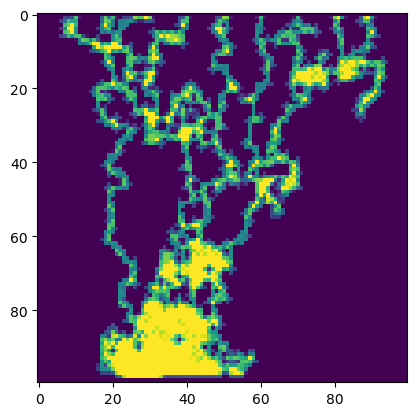

In [148]:
nSteps = 200
angiogenesisModel.evolveSystem(nSteps)
plt.figure()
plt.imshow(angiogenesisModel.nMatrix[:,:,-1])

print(angiogenesisModel.nMatrix[:,:,-1])

In [149]:
print(len(angiogenesisModel.tipCells))

49


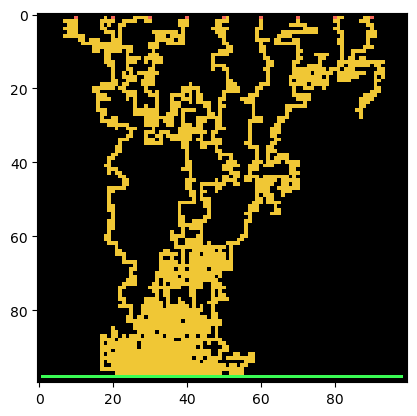

In [150]:
plt.figure()
plt.imshow(angiogenesisModel.getPicture(tipCellLocations, proliferatingLocations, angiogenesisModel.occupiedCells))

## Combinación con modelo avascular

In [177]:
from TumorModel import Tissue
from TumorModel import Therapy
from TumorModel import CellType
from TumorModel import TherapyType

In [178]:


width = 150
height = 150

centerX = int(width/2)
centerY = int(width/2)

tissue = Tissue(width, height)

#Inicializamos el tejido
tissue.addProliferatingCell(centerX, centerY, False,0)
tissue.addProliferatingCell(centerX + 1,centerY, False,0)
tissue.addProliferatingCell(centerX - 1, centerY, False,0)
tissue.addProliferatingCell(centerX, centerY + 1, False,0)
tissue.addProliferatingCell(centerX, centerY - 1, False,0)


nSteps = 300
tissue.evolveWithMovie(nSteps, True)

100%|█████████████████████████████████████████| 300/300 [00:39<00:00,  7.64it/s]


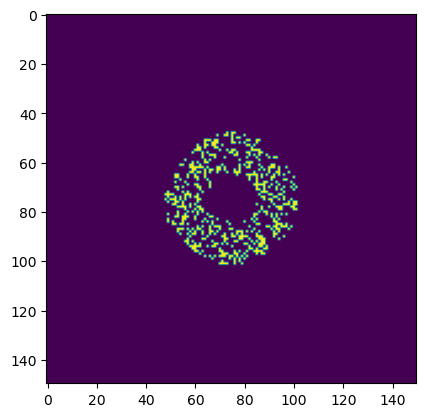

In [179]:
tumorSlices = tissue.evolutionMovie

proliferatingPositions = np.zeros((height, width))
finalSlice = tumorSlices[:,:,:,-1]
for i in range(0,height):
    for j in range(0,width):
        if((finalSlice[i,j,:] == CellType.PROLIFERATING.value).all()):
            proliferatingPositions[i,j] = 1
plt.figure()
plt.imshow(proliferatingPositions)

569.0
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.49288528 0.49572555 ... 0.49552374 0.49268292 0.        ]
 [0.         0.49576787 0.49863566 ... 0.4984322  0.49556387 0.        ]
 ...
 [0.         0.50206903 0.50499736 ... 0.50471585 0.50178715 0.        ]
 [0.         0.49921039 0.50211077 ... 0.50183183 0.49893103 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


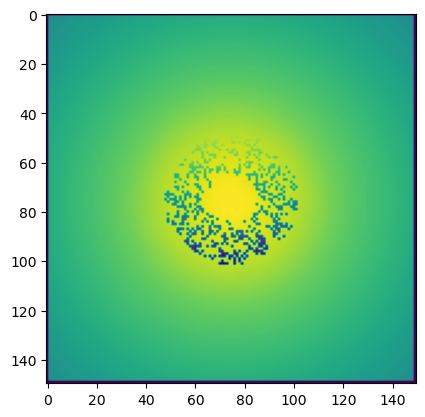

In [180]:
angiogenesisModel = AngiogenesisModel(width, height)
angiogenesisModel.setInitialConcentrations(proliferatingPositions)
tipCellLocations = np.zeros((height, width))
for i in range(1, width - 1):
    if(i%10 == 0):
        tipCellLocations[1,i] = 1
        tipCellLocations[height-2,i] = 1
        tipCellLocations[i,1] = 1
        tipCellLocations[i, width-2] = 1

angiogenesisModel.setTipCells(tipCellLocations)


plt.figure()
plt.imshow(angiogenesisModel.cInitial)

print(angiogenesisModel.cInitial)

In [181]:
nSteps = 100
angiogenesisModel.evolveSystem(nSteps)


100%|█████████████████████████████████████████| 100/100 [01:01<00:00,  1.62it/s]


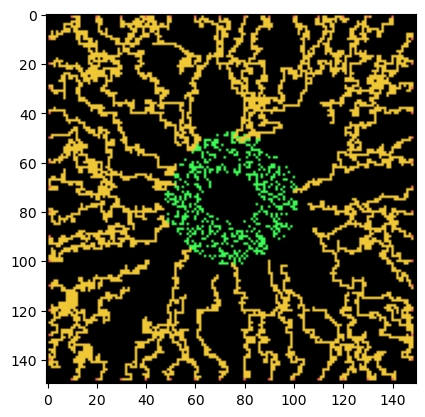

In [182]:
plt.figure()
plt.imshow(angiogenesisModel.getPicture(tipCellLocations, proliferatingPositions, angiogenesisModel.occupiedCells))